In [1]:
# Set your own project id here
PROJECT_ID = 'disaster_tweets'
from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)

In [2]:
from fastai import *
from fastai.text import *
import pandas as pd

In [3]:
train_df= pd.read_csv('../input/nlp-getting-started/train.csv')
test_df= pd.read_csv('../input/nlp-getting-started/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.iloc[0]["text"]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [5]:
print(train_df.keyword.unique())
print(train_df.location.unique())

[nan 'ablaze' 'accident' 'aftershock' ... 'wounds' 'wreck' 'wreckage' 'wrecked']
[nan 'Birmingham' 'Est. September 2012 - Bristol' 'AFRICA' ... '#NewcastleuponTyne #UK' 'Vancouver, Canada' 'London '
 'Lincoln']


# Language Model

In [6]:
path = Path('../input/nlp-getting-started')

In [12]:
df_lm = pd.DataFrame({
    "text" : np.concatenate((train_df["text"].values, test_df["text"].values), axis = 0) 
})

In [23]:
data_lm = (TextList.from_df(df_lm).split_by_rand_pct(0.1).label_for_lm().databunch(bs=32))

In [26]:
data_lm.show_batch()

idx,text
0,orders in xxmaj california xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj
1,/ t.co / xxunk # xxup us http : / / t.co / xxunk xxbos ( xxup official xxup vid ) > # xxunk > > https : / / t.co / xxunk > > @trubgme xxmaj xxunk xxup xxunk > > # xxup armageddon . xxbos xxmaj tomorrow is the day we start armageddon # xxunk xxrep 4 ? xxbos xxmaj xxunk does comedy : xxunk : xxmaj working
2,nowplaying # listenlive xxbos xxmaj come and join us xxmaj tomorrow ! \n xxmaj august 7 2015 at xxmaj xxunk : xxmaj blazing the xxmaj xxunk to the xxmaj xxunk xxmaj world of xxmaj marketing ... http : / / t.co / xxunk xxbos xxmaj morgan xxmaj silver xxmaj dollar xxunk s xxmaj gem xxup bu xxup xxunk xxmaj xxunk xxmaj xxunk xxmaj blazing xxup ms xxrep 5 +
3,handbags xxmaj cross xxmaj body xxmaj xxunk xxmaj pattern xxmaj satchel xxmaj xxunk xxmaj shoulder xxmaj bags xxmaj white http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj status : last seen buying body bags . xxbos xxunk xxunk i 'm xxunk by only xxunk cross - body bags . i really like xxmaj xxunk xxmaj xxunk bags : machine xxunk . http
4,levels ' of xxmaj civilian xxmaj casualties \n \n xxmaj in news from xxmaj afghanistan the xxmaj united ... http : / / t.co / xxunk xxbos xxmaj need to stop xxunk things up because when everything eventually xxunk the casualties just keep getting higher and higher xxbos xxmaj xxunk xxmaj casualties xxmaj all xxmaj across xxmaj the xxmaj xxunk xxmaj war xxmaj being xxmaj xxunk xxmaj on xxmaj


In [27]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 4.37E-02


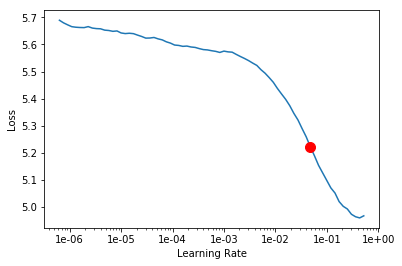

In [30]:
learn.recorder.plot(skip_end=15, suggestion = True)

In [32]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.215210,3.052489,0.462500,00:06
1,3.000025,2.903714,0.481250,00:06
2,2.703048,2.843615,0.495261,00:06
3,2.453274,2.826005,0.500206,00:06
4,2.306528,2.826399,0.500515,00:06


In [33]:
learn.save('fit_head')

In [34]:
learn.load('fit_head');

In [35]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.10E-05


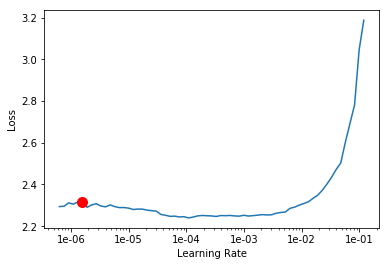

In [37]:
learn.lr_find()
learn.recorder.plot(skip_end=15, suggestion = True)

In [38]:
learn.fit_one_cycle(5, 1e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.253503,2.827978,0.500137,00:08
1,2.241463,2.827185,0.501168,00:08
2,2.236468,2.826401,0.501648,00:08
3,2.228069,2.825619,0.501339,00:08
4,2.228483,2.824322,0.501374,00:08


In [39]:
learn.save('fine_tuned')

In [40]:
learn.load('fine_tuned');

In [41]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [43]:
path

PosixPath('../input/nlp-getting-started')

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(train_df, test_size = 0.3)

In [52]:
data_classifier = (TextDataBunch.from_df('.', X_train, X_val, test_df, text_cols = "text", label_cols = "target", vocab = data_lm.vocab))

In [53]:
data_classifier.show_batch()

text,target
xxbos _ \n xxrep 5 ? xxup retweet \n xxrep 7 ? \n xxrep 5 ? xxup follow xxup all xxup who xxup rt \n xxrep 7 ? \n xxrep 5 ? xxup xxunk \n xxrep 7 ? \n xxrep 5 ? xxup gain xxup with \n xxrep 7 ? \n xxrep 5 ? xxup follow ? xxunk # xxup xxunk,0
xxbos xxup info xxup s. xxup xxunk : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup xxunk xxup xxunk . xxup xxunk 05 . xxup curfew xxup in xxup xxunk xxup until xxunk xxup xxunk xxup xxunk xxup foxtrot 5 & & xxup foxtrot 6 xxup xxunk . xxup xxunk : 10 .,0
xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup xxunk xxup xxunk . xxup xxunk 05 . xxup curfew xxup in xxup xxunk xxup until xxunk xxup xxunk xxup xxunk xxup foxtrot 5 & & xxup foxtrot 6 xxup xxunk . xxup xxunk : 10 . xxup xxunk : xxunk / 6 .,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj no # news of # hostages in # xxmaj libya \n \n http : / / t.co / xxunk \n \n # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1


In [54]:
data_classifier.save('data_clas.pkl')

In [67]:
learn = text_classifier_learner(data_classifier, AWD_LSTM)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5329 items)
x: TextList
xxbos xxmaj sitting around a fire sounds great right about now,xxbos xxmaj people really still be having curfew even when they 're 18 & & xxunk high school ? ?,xxbos i xxunk and i slip and i fall off that cliff,xxbos xxmaj owner of xxmaj chicago - xxmaj area xxmaj gay xxmaj bar xxmaj admits to xxmaj arson xxmaj scheme http : / / t.co / xxunk via xxunk # xxup lgbt | https : / / t.co / xxunk,xxbos xxmaj tornado has to make the playoffs . xxmaj they have 3 guys with xxunk already and they just added xxmaj xxunk and xxmaj price
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (2284 items)
x: TextList
xxbos xxmaj ah yes the xxunk are totally xxunk xxmaj america . i can see buildings burning and xxunk crashing into schools wow,xxbos i tell my xxunk i do n't wanna hang out and they text me saying ' we 're coming over ' honestly do you have a death wish,xxbos xxunk more like xxup blown xxup up amirite,xxbos xxup 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-05
Min loss divided by 10: 1.20E-02


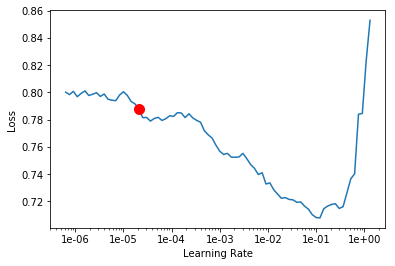

In [68]:
learn.lr_find()
learn.recorder.plot(suggestion= True)

In [69]:
learn.fit_one_cycle(5, 5e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.685988,0.552783,0.707968,00:03
1,0.632160,0.541583,0.721979,00:03
2,0.598994,0.492853,0.765762,00:03
3,0.590671,0.485854,0.773205,00:03
4,0.583746,0.492341,0.767513,00:03


In [70]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.596241,0.517933,0.770140,00:03
1,0.578800,0.483241,0.782837,00:03
2,0.573459,0.455426,0.788529,00:03
3,0.551968,0.449765,0.790718,00:03
4,0.540895,0.444363,0.795096,00:03


In [71]:
learn.freeze_to(-3)
learn.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.534637,0.450615,0.788091,00:05
1,0.522663,0.459475,0.799475,00:04
2,0.513927,0.426153,0.809545,00:04
3,0.498138,0.421110,0.811296,00:04
4,0.499696,0.420455,0.811734,00:04


In [72]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.476790,0.419875,0.814799,00:06
1,0.483248,0.417546,0.813047,00:06
2,0.480473,0.415303,0.813923,00:05
3,0.474335,0.411812,0.813047,00:06
4,0.467587,0.415711,0.815674,00:06
5,0.462010,0.412949,0.814799,00:06
6,0.454648,0.417162,0.813923,00:05
7,0.453192,0.420203,0.812609,00:06
8,0.456722,0.410784,0.816550,00:05
9,0.452596,0.417926,0.810858,00:06


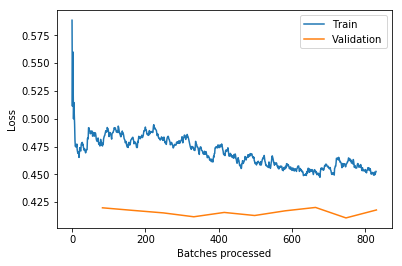

In [73]:
learn.recorder.plot_losses()

In [79]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data_classifier.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [80]:
test_preds = get_preds_as_nparray(DatasetType.Test)
preds = []

In [81]:
for i in test_preds:
    preds.append(np.argmax(i))

In [83]:
sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sub.head(3)

,id,target
0,0,0
1,2,0
2,3,0


In [ ]:
sub['target'] = preds
sub.to_csv('submission.csv', index=False)
sub.head(3)